**Projeye Genel Bakış**

Duygu durumlarını Happy, Suprised, Neutral olarak belirledim. Hazır dataset'lerden en çok veriye sahip olanları seçtim ki doğruluk oranı yüksek olsun.

- Veri seti olarak FER-2013'ün yalnızca Happy, Suprise, Neutral verilerini kullandım.
- Model oluşturmak için tenserflow ve keras kütüphanelerini yükledim.
- Yüz algılama için OpenCV; veri durumlarını gözlemlemek için de matpolotlib kullandım.

Her adımı yorum satırıyla açıklamaya çalıştım, gerekli yerlerde sunum sırasında ek yorumumu katabilirim.

In [57]:
from google.colab import files
import zipfile #zip formatında yükleyeceğiz

# veri setini yükle. yerel dosyalardan
uploaded = files.upload()

# ZIP dosyasını çıkar
zip_file_name = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("dataset")

Saving archive.zip to archive.zip


In [58]:
import os  #dosya dizinlerini işlemek için
import cv2 # görüntüyü işlemek için(okuma, görüntüleme, yeniden boyutlandırma)
import numpy as np
from sklearn.model_selection import train_test_split

# dizin yolları
train_dir = "dataset/train"
test_dir = "dataset/test"

# bu fonksiyon dizinlerden(train veya test) image ve label'larını yüklüyor
def load_images_from_directory(directory):
    data = []
    labels = []
    categories = ["happy", "neutral", "surprise"]  # klasör adları sınıf isimleri

    for category in categories:
        path = os.path.join(directory, category)
        class_label = categories.index(category)  # labels = 0, 1, 2 olarak ayarlar
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name) #path ile image ismini birleştirip opencv işlemlerine hazırlar
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # read image and load grayscale = görüntüyü siyah-beyaz olarak yükle
                img = cv2.resize(img, (48, 48))  # görüntüyü 48x48 boyutuna getir
                data.append(img)
                labels.append(class_label)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")  #resim yüklenemezse exception yazdır

    return np.array(data), np.array(labels)

# train ve test setlerini yükle - data, emotion label
X_train, y_train = load_images_from_directory(train_dir)
X_test, y_test = load_images_from_directory(test_dir)

# image verilerini normalize et ve CNN için yeniden şekillendir
X_train = X_train.reshape(-1, 48, 48, 1) / 255.0  # Normalize
X_test = X_test.reshape(-1, 48, 48, 1) / 255.0

In [59]:
from tensorflow.keras.utils import to_categorical

# label'ları one-hot encode ile machine learning model geliştirmeye daha uygun hale getiriyoruz
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

Convolutional Neural Network (CNN) oluşturmak için aşamalar:

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN modeli oluştur
model = Sequential() #model oluşturur ve içi boş aktmanlara ayırır

# 1. convolutional(number of filters, (filter)kernel_size, relu->neg=0 poz=aynı) ve pooling layer ekleme
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2))) #convo layer'ların boyutunu kısıtlar

# 2. convolutional ve pooling layers
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3. fully connected layers
model.add(Flatten()) # conv. label outputları -> tek bir vektöre dizer. Şöyle ||||||| -> ---------------- gibi.
# dense: complex patternlerive ilişkileri flattened labeldan kullanır
model.add(Dense(128, activation='relu')) # bu katmandaki her nöronu önceki katmanlara bağlar
model.add(Dropout(0.5))  # overfitting'i önlemek için önceki katmandaki nöronların %50'sini droplar
model.add(Dense(3, activation='softmax'))  # final prediction layer, 3 category için softmax ile olasılıklar oluşturur

model.summary()  # modelin özetini yazdır

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 838,531 (3.20 MB)

 Trainable params: 838,531 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [63]:
# modeli eğit
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # eğitim döngüsü sayısı
    batch_size=32,  # mini batch boyutu
    verbose=1  # eğitim sırasında detaylı çıktı
)

Epoch 1/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 51s 103ms/step - accuracy: 0.5407 - loss: 0.9539 - val_accuracy: 0.7335 - val_loss: 0.6508
Epoch 2/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.7273 - loss: 0.6603 - val_accuracy: 0.7548 - val_loss: 0.5755
Epoch 3/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.7611 - loss: 0.5811 - val_accuracy: 0.7791 - val_loss: 0.5248
Epoch 4/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - accuracy: 0.7848 - loss: 0.5261 - val_accuracy: 0.7751 - val_loss: 0.5187
Epoch 5/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - accuracy: 0.8037 - loss: 0.4823 - val_accuracy: 0.7858 - val_loss: 0.5127
Epoch 6/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 80s 99ms/step - accuracy: 0.8180 - loss: 0.4555 - val_accuracy: 0.8043 - val_loss: 0.4832
Epoch 7/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 83s 101ms/step - accuracy: 0.8347 - loss: 0.4240 - val_accuracy: 0.8004 - val_loss: 0.4975
Epoch 8/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 83s 104ms/step - accuracy: 0.8521 - loss: 0.

In [68]:
from tensorflow.keras.models import save_model

# modeli kaydet
model.save('emotion_recognition_model.keras')

In [69]:
from google.colab import drive

# modeli Drive'a kaydet
model.save('/content/drive/My Drive/emotion_recognition_model.keras')

Train edilmiş modeli eklemek için:

In [73]:
#from tensorflow.keras.models import load_model

# Kaydedilmiş modeli yüklelemek için
#model = load_model('emotion_recognition_model.keras')

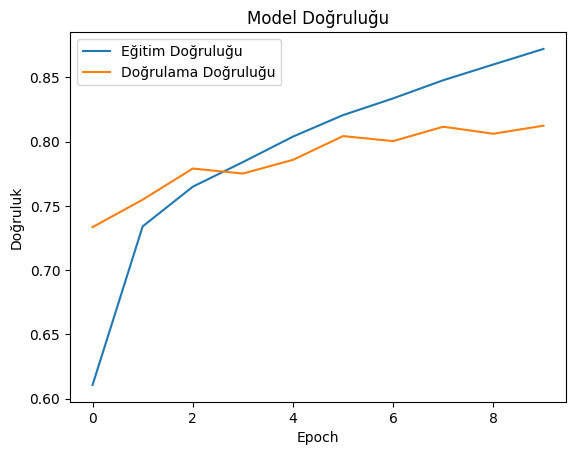

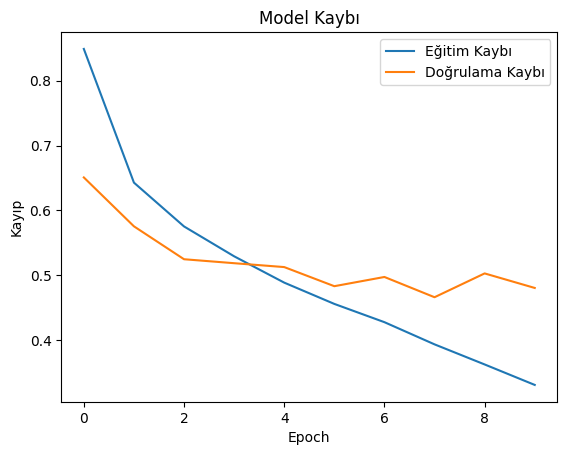

In [74]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğu
plt.plot(history.history['accuracy'], label='Eğitim Seti Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Seti Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# eğitim ve doğrulama kaybı
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

In [85]:
# test verileri üzerine tahmin üretimi
y_pred = model.predict(X_test)

# predicted class label
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step


In [78]:
from sklearn.metrics import accuracy_score

# test doğruluk oranı hesaplaması
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Test doğruluk oranı: {accuracy * 100:.2f}%")

Test doğruluk oranı: 81.24%


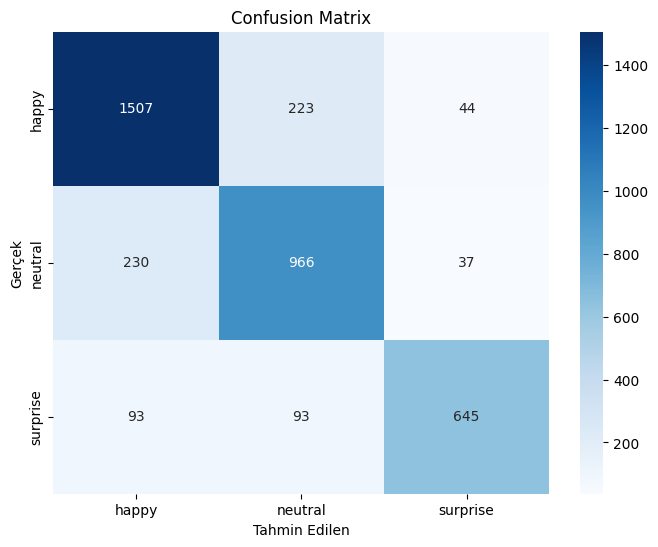

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# create
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["happy", "neutral", "surprise"], yticklabels=["happy", "neutral", "surprise"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()

In [119]:
from google.colab import files
import cv2
import numpy as np

uploaded = files.upload()
# uploaded dosya adı
img_file_name = list(uploaded.keys())[0]

Saving PrivateTest_1735299.jpg to PrivateTest_1735299.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tahmin Edilen Sınıf: happy
happy: 98.07% 

neutral: 1.35% 

surprise: 0.59% 



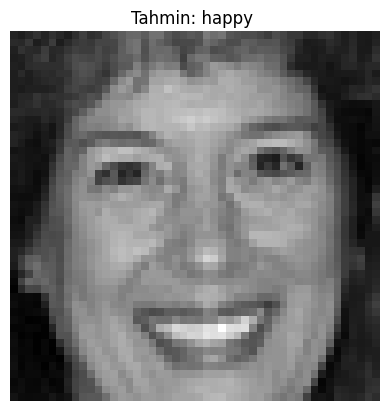

In [120]:
# görseli yükleyip işleme
img = cv2.imread(img_file_name, cv2.IMREAD_GRAYSCALE)

# resize ve normalize
img_resized = cv2.resize(img, (48, 48))
img_normalized = img_resized / 255.0  # normalize et
img_reshaped = img_normalized.reshape(1, 48, 48, 1)  # 48x48 model girişine göre ayarla

# prediction
prediction = model.predict(img_reshaped)
predicted_class = np.argmax(prediction)  # sınıf tahmini
class_labels = ["happy", "neutral", "surprise"]
print(f"Tahmin Edilen Sınıf: {class_labels[predicted_class]}")

# prediction yüzdeleri
for i, label in enumerate(class_labels):
    print(f"{label}: {prediction[0][i] * 100:.2f}% \n")

# görsel+predicted class
plt.imshow(img_resized, cmap="gray")
plt.title(f"Tahmin: {class_labels[predicted_class]} ")
plt.axis("off")
plt.show()